In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch_geometric
import torch_geometric.nn as geo_nn
from torch_geometric.data import Data
from torch_geometric.loader import ClusterData, ClusterLoader

In [3]:
from torchvision import datasets, transforms
from torch.nn import BCEWithLogitsLoss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import gc
import psutil

from util.CustomDatasets import PatientDataset
from util.GCN_GAT import GCN_GAT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

SEED=79
torch.manual_seed(SEED);

In [4]:
all_patients_dict = torch.load('./data/adj_graph/img_dict.pth')
keys_temp = list(all_patients_dict.keys())[:10]

patient_max = None
max_edges = 0
total_nodes = 0
for k in all_patients_dict.keys():
    if k in keys_temp:
        print(f"{k}: total edges: {len(all_patients_dict[k]['edge_list'][0])} total nodes: {len(all_patients_dict[k]['enc'])}")
    if(len(all_patients_dict[k]['edge_list'][0]) > max_edges):
        max_edges = len(all_patients_dict[k]['edge_list'][0])
        patient_max = k
    total_nodes += len(all_patients_dict[k]['enc'])
print(f'\n{patient_max=}, edges: {max_edges}')
print(f'Mean nodes: {total_nodes / len(all_patients_dict.keys())}')
print(f'Amt keys: {len(all_patients_dict.keys())}')

001_01: total edges: 7400 total nodes: 1047
001_02: total edges: 6208 total nodes: 875
001_03: total edges: 1756 total nodes: 264
001_04: total edges: 1238 total nodes: 187
001_05: total edges: 1612 total nodes: 236
001_06: total edges: 2320 total nodes: 334
002_01: total edges: 9914 total nodes: 1357
002_02: total edges: 5800 total nodes: 850
002_03: total edges: 5924 total nodes: 879
002_04: total edges: 4308 total nodes: 629

patient_max='051_01', edges: 23720
Mean nodes: 695.802371541502
Amt keys: 506


In [5]:
SPLIT = [406, 50, 50] 
dataset = PatientDataset(all_patients_dict)

train_set, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,      # 80%, 10%, 10%
                                                generator=torch.Generator(device=device))


# batch_size MUST BE 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, generator=torch.Generator(device))

In [6]:
model = GCN_GAT(heads=4).to(device)

In [7]:
all_labels = [] # list of all labels s.t. x_i in {0,1}
for _, v in all_patients_dict.items():
    all_labels.append(v['label'].item())

In [8]:
# Get the class weighting
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)

loss_fn = BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1]))

In [9]:
def write_out(s: str, to_print=True, path='progress.txt'):
    if to_print:
        print(s)
    with open(path, 'a') as file:
        file.write(s + '\n')

with open('progress.txt', 'w') as file:
    file.write('Starting training: \n\n')
with open('loss.txt', 'w') as file:
    file.write('Starting training: \n\n')

In [10]:
# Hyper paramaters
EPOCHS = 50
LR = 1e-3 

optimizer = torch.optim.Adam([{'params': model.parameters(),'lr': LR}])
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

optimizer, scheduler.factor# scheduler.gamma

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 0.5)

In [ ]:
print('Starting Training:')

loss_arr = []
for epoch in range(EPOCHS):
    write_out(f'Epoch: {epoch+1}/{EPOCHS}', to_print=False)
    COUNT = 0
    epoch_loss = 0
    for train_batch in train_loader:
        COUNT += 1 # For progress check

        # Zero the grad
        optimizer.zero_grad()

        # Get info from the loader
        k = train_batch[0][0] # patient id
        v = train_batch[1] # dict with 'enc', 'label', 'edge_list'
        src, dest = v['edge_list'] # edges for the graph

        # Output relevent information
        write_out(f"\n----------\nMemory at start of loop (RSS): {psutil.Process().memory_info().rss / 1e6:.2f} MB", to_print=False)
        write_out(f'Patient: {k} ({v["label"].item()}) ({COUNT}/{len(train_loader)})', to_print=False)

        # Get embedding and label, format them and edges
        node_emb = v['enc'].squeeze(0)
        label = v['label'].squeeze(0)
        edge_index = torch.tensor([src, dest], dtype=torch.long)

        # Create data variable, and validate
        data = Data(x=node_emb, edge_index=edge_index.contiguous()).to(device)
        data.validate(raise_on_error=True)

        logit = model(data)

        # Find the loss
        loss = loss_fn(logit.view(-1), label.float().view(-1))
        epoch_loss += loss.item()

        # Update GCN
        loss.backward()
        optimizer.step()

        # Print info
        write_out(f'Logits: {logit}\nLoss: {loss.item()}', to_print=False)
        write_out("----------", to_print=False)

        # Watch for memory leaks
        del train_batch, data, node_emb, label
        torch.cuda.empty_cache()
        gc.collect()
        
    
    mean_loss = epoch_loss/len(train_loader)
    scheduler.step(mean_loss)
    
    loss_arr.append(mean_loss)
    write_out(f'{mean_loss=}', to_print=False)
    write_out(f'Epoch: {epoch+1} | {mean_loss=}', path='loss.txt', to_print=True)
write_out(f'{loss_arr=}', path='loss.txt', to_print=False)

Starting Training:
Epoch: 1 | mean_loss=0.7690330463383586
Epoch: 2 | mean_loss=0.7782974191046701
Epoch: 3 | mean_loss=0.7782135715185128
Epoch: 4 | mean_loss=0.8757604607220354
Epoch: 5 | mean_loss=0.7693275875352287
Epoch: 6 | mean_loss=0.771853111354001
Epoch: 7 | mean_loss=0.7662775647170438
Epoch: 8 | mean_loss=0.7688060093102197
Epoch: 9 | mean_loss=0.7696845310882394
Epoch: 10 | mean_loss=0.7480881408664394
Epoch: 11 | mean_loss=0.7371950877711103
Epoch: 12 | mean_loss=0.7965305475105205
Epoch: 13 | mean_loss=0.7586734943789214
Epoch: 14 | mean_loss=0.7196089016833329
Epoch: 15 | mean_loss=0.7266182929204015
Epoch: 16 | mean_loss=0.7218153671971683
Epoch: 17 | mean_loss=0.6950596946066824
Epoch: 18 | mean_loss=0.6891755724481761
Epoch: 19 | mean_loss=0.690172915828639
Epoch: 20 | mean_loss=0.6520003514190026
Epoch: 21 | mean_loss=0.6852772728416133
Epoch: 22 | mean_loss=0.6777710996825119
Epoch: 23 | mean_loss=0.6601174185648927


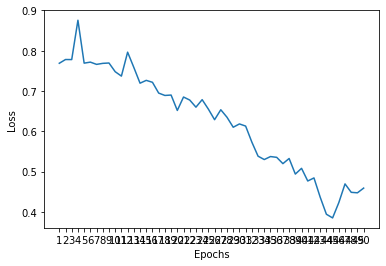

In [12]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [14]:
test_loader = torch.utils.data.DataLoader(val_set, batch_size=1)
pred = []
labels = []
for test_batch in test_loader:
    # Get info from the loader
    k = test_batch[0][0] # patient id
    v = test_batch[1] # dict with 'enc', 'label', 'edge_list'
    src, dest = v['edge_list'] # edges for the graph
    
    # Get embedding and label, format them and edges
    node_emb = v['enc'].squeeze(0)
    label = v['label'].squeeze(0)
    edge_index = torch.tensor([src, dest], dtype=torch.long)

    # Create data variable, and validate
    data = Data(x=node_emb, edge_index=edge_index.contiguous()).to(device)
    
    with torch.no_grad():
        logit = model(data)
        pred.append((torch.sigmoid(logit) > 0.5).float().item())
        labels.append(label.item())

In [15]:
amt_corr = 0
for i in range(len(pred)):
    if pred[i] == labels[i]:
        amt_corr += 1
amt_corr / len(pred)

0.64

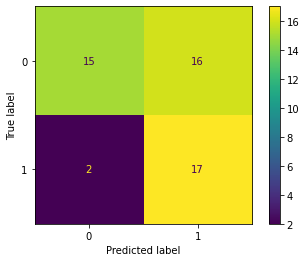

In [16]:
cm = confusion_matrix(labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [17]:
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        31
           1       0.52      0.89      0.65        19

    accuracy                           0.64        50
   macro avg       0.70      0.69      0.64        50
weighted avg       0.74      0.64      0.64        50



In [18]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 309516 KiB |   2824 MiB |  50623 GiB |  50622 GiB |
|       from large pool | 302296 KiB |   2793 MiB |  50041 GiB |  50041 GiB |
|       from small pool |   7220 KiB |     40 MiB |    581 GiB |    581 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 309516 KiB |   2824 MiB |  50623 GiB |  50622 GiB |
|       from large pool | 302296 KiB |   2793 MiB |  50041 GiB |